In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [20]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if(0.1*i == 0.5):
            continue
            
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(21,1)


In [21]:
# Activation functions
# ReLU 
# if x > 0 return x else return 0
def ReLU(x):
    return np.where(x > 0, x, 0)

def ReLU_derivative(x):
    return np.where(x > 0, 1, 0)

# Sigmoid
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def sigmoid_derivative(x):
    return x * (1 - x)

In [22]:
def show_result_plt(x, y, pred_y):
    plt.subplot(2,2,1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
        
    plt.subplot(2,2,2)
    plt.text(0, 0, f'Accuracy: {sum(pred_y == y)/y.size}', fontsize = 16, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')

In [38]:
class Layer:
    def __init__(self, input_size, output_size,activation_function="sigmoid"):
        # random initialization
        self.W = np.random.randn(input_size, output_size)
        self.b = np.zeros((1, output_size))
        self.z = None
        self.v_w = 0
        self.v_b = 0
        self.input = None
        self.output = None
        self.activation_function = activation_function
    def forward(self, input_data):
        self.input = input_data
        self.z = np.dot(input_data, self.W) + self.b
        if self.activation_function == "sigmoid":
            self.output = sigmoid(self.z)
        elif self.activation_function == "ReLU":
            self.output = ReLU(self.z)
        elif self.activation_function == "linear":
            self.output = self.z
        else:
            raise ValueError("Unsupported activation function")
        return self.output


        '''
        loss_derivative * sigmoid_derivative(self.output) C對於z的偏微分= C對於output的偏微分 * output對於z的偏微分
        # gradient of W 
        ∂W/∂L​=(X^T)*δ
        # gradient of b
        ∂b/∂L​=∑δ
        '''
        # self.input.T 是input的轉置矩陣
    def backward(self, loss_derivative, learning_rate,optimize,decay_rate):
        if self.activation_function == "sigmoid":
            activation_derivative = sigmoid_derivative(self.output)
        elif self.activation_function == "ReLU":
            activation_derivative = ReLU_derivative(self.output)
        elif self.activation_function == "linear":
            activation_derivative = 1
        else:
            raise ValueError("Unsupported activation function")

        delta = loss_derivative * activation_derivative
        dw = np.dot(self.input.T, delta)
        db = np.sum(delta)
        if optimize == "SGD":
            self.W -= learning_rate * dw
            self.b -= learning_rate * db
        elif optimize == "momentum":
            self.v_w = decay_rate * self.v_w + learning_rate * dw
            self.W -= self.v_w
            self.v_b = decay_rate * self.v_b + learning_rate * db
            self.b -= self.v_b
        else:
            raise ValueError("Unsupported optimize function")
        return np.dot(delta, self.W.T)
    


In [24]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.loss = []
        self.predictions = None
        
    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, loss_derivative, learning_rate,optimize,decay_rate):
        # backward
        for layer in reversed(self.layers):
            loss_derivative = layer.backward(loss_derivative, learning_rate,optimize,decay_rate)

    def mse_loss(self, y, y_hat):
        return np.mean((y - y_hat) ** 2)
    
    def mse_loss_derivative(self, y, y_hat):
        return 2 * (y_hat - y) / y.size
    
    def train(self, X, y, epochs, learning_rate,optimize="SGD",decay_rate=0.9):
        for epoch in range(epochs):
            output=self.forward(X)
            loss = self.mse_loss(y, output)
            loss_derivative = self.mse_loss_derivative(y, output)
            self.backward(loss_derivative, learning_rate,optimize,decay_rate)
            if epoch % 1000 == 0:
                self.loss.append(loss)
                print(f'Epoch {epoch}| Loss: {loss} | Accuracy: {self.accuracy(X, y)}')
                
        self.predictions = output
        
    
    def predict(self, X):
        return self.forward(X)
    
    def show_result(self,x, y):
        print(f"Accuracy: {self.accuracy(x, y)}")
        print("Prediction : ")
        for i in range(y.size):
            print(f"Iter {i+1} | Ground truth: {y[i]} | Prediction: {self.predictions[i]}")
        
        plt.plot(self.loss)
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
        
        show_result_plt(x, np.round(y), np.round(self.predictions))
        

    def accuracy(self, X, y):
        # 大於0.5為1，小於0.5為0
        return sum(np.round(self.predict(X)) == y) / y.size
    

Epoch 0| Loss: 0.24689750098350557 | Accuracy: [0.57]
Epoch 1000| Loss: 0.11062330418208612 | Accuracy: [0.95]
Epoch 2000| Loss: 0.055235668439430334 | Accuracy: [0.97]
Epoch 3000| Loss: 0.03588869912400353 | Accuracy: [0.98]
Epoch 4000| Loss: 0.026976009205631764 | Accuracy: [0.98]
Epoch 5000| Loss: 0.021977327195205457 | Accuracy: [0.99]
Epoch 6000| Loss: 0.018804803572303776 | Accuracy: [0.99]
Epoch 7000| Loss: 0.016615633027211786 | Accuracy: [0.99]
Epoch 8000| Loss: 0.01501216303810084 | Accuracy: [0.99]
Epoch 9000| Loss: 0.013784558092492285 | Accuracy: [0.99]
Accuracy: [0.99]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.01505087]
Iter 2 | Ground truth: [1] | Prediction: [0.99846974]
Iter 3 | Ground truth: [0] | Prediction: [0.00036841]
Iter 4 | Ground truth: [0] | Prediction: [0.00017262]
Iter 5 | Ground truth: [1] | Prediction: [0.99890585]
Iter 6 | Ground truth: [1] | Prediction: [0.99957083]
Iter 7 | Ground truth: [1] | Prediction: [0.96822233]
Iter 8 | Ground tr

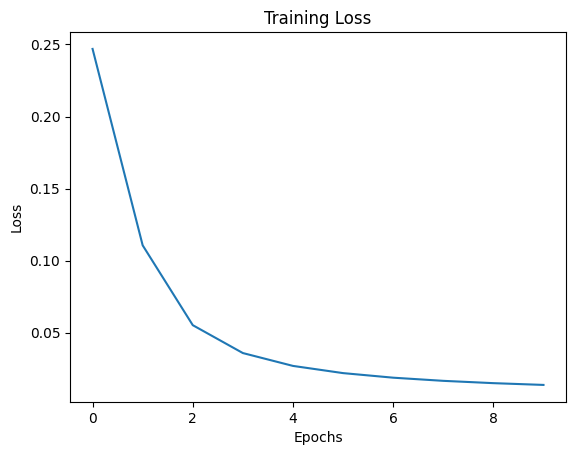

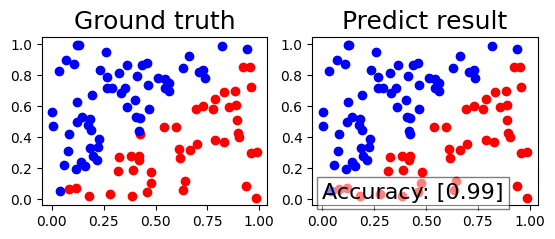

In [25]:
x, y= generate_linear()

# 訓練參數
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 10000
learning_rate = 0.1

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1))
model.add_layer(Layer(hidden_size1, hidden_size2))
model.add_layer(Layer(hidden_size2, output_size))

# 訓練模型
model.train(x, y, epochs, learning_rate)
model.show_result(x,y)

Epoch 0| Loss: 0.27280651656706684 | Accuracy: [0.47619048]
Epoch 1000| Loss: 0.2473700476031056 | Accuracy: [0.52380952]
Epoch 2000| Loss: 0.24324501179177216 | Accuracy: [0.61904762]
Epoch 3000| Loss: 0.2367564846815729 | Accuracy: [0.71428571]
Epoch 4000| Loss: 0.22610219623765526 | Accuracy: [0.76190476]
Epoch 5000| Loss: 0.20923117959506354 | Accuracy: [0.76190476]
Epoch 6000| Loss: 0.1820250854779709 | Accuracy: [0.85714286]
Epoch 7000| Loss: 0.14266938327439826 | Accuracy: [0.9047619]
Epoch 8000| Loss: 0.10663041544323106 | Accuracy: [0.9047619]
Epoch 9000| Loss: 0.0815331031273653 | Accuracy: [0.9047619]
Accuracy: [0.9047619]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.06295848]
Iter 2 | Ground truth: [1] | Prediction: [0.9369361]
Iter 3 | Ground truth: [0] | Prediction: [0.0896027]
Iter 4 | Ground truth: [1] | Prediction: [0.93175659]
Iter 5 | Ground truth: [0] | Prediction: [0.16214027]
Iter 6 | Ground truth: [1] | Prediction: [0.9005316]
Iter 7 | Ground truth: 

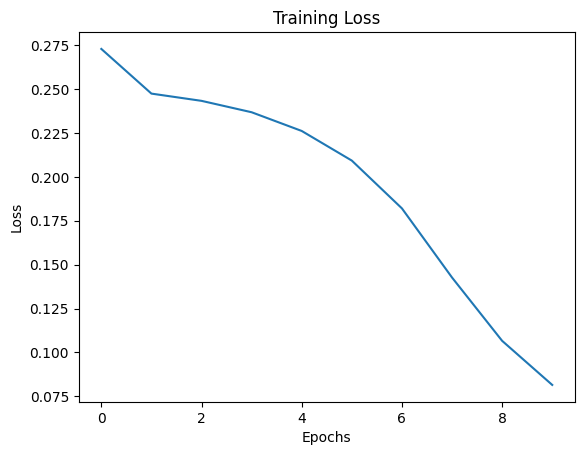

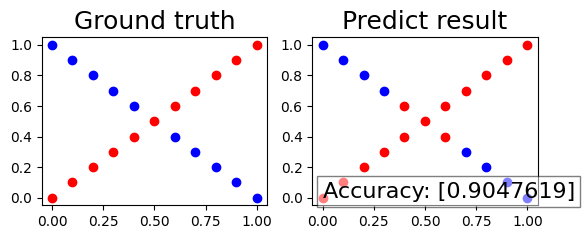

In [26]:
# 輸入數據和標籤
x, y= generate_XOR_easy()
# 訓練模型
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 10000
learning_rate = 0.1

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1))
model.add_layer(Layer(hidden_size1, hidden_size2))
model.add_layer(Layer(hidden_size2, output_size))

model.train(x, y, epochs, learning_rate)
model.show_result(x,y)

# Try different activation function

Epoch 0| Loss: 0.13520836427704513 | Accuracy: [0.88]
Epoch 1000| Loss: 0.013654473041100663 | Accuracy: [1.]
Epoch 2000| Loss: 0.0077547745379694085 | Accuracy: [1.]
Epoch 3000| Loss: 0.005061873426633877 | Accuracy: [1.]
Epoch 4000| Loss: 0.0035480745500120624 | Accuracy: [1.]
Epoch 5000| Loss: 0.0026128306472791023 | Accuracy: [1.]
Epoch 6000| Loss: 0.0019989365140947964 | Accuracy: [1.]
Epoch 7000| Loss: 0.0015777177462268435 | Accuracy: [1.]
Epoch 8000| Loss: 0.001278320520897401 | Accuracy: [1.]
Epoch 9000| Loss: 0.001058754593576857 | Accuracy: [1.]
Accuracy: [1.]
Prediction : 
Iter 1 | Ground truth: [1] | Prediction: [0.99999996]
Iter 2 | Ground truth: [0] | Prediction: [0.00022941]
Iter 3 | Ground truth: [1] | Prediction: [0.99992894]
Iter 4 | Ground truth: [1] | Prediction: [0.99993676]
Iter 5 | Ground truth: [0] | Prediction: [5.58334471e-10]
Iter 6 | Ground truth: [0] | Prediction: [1.16997076e-11]
Iter 7 | Ground truth: [0] | Prediction: [5.14742015e-15]
Iter 8 | Ground tr

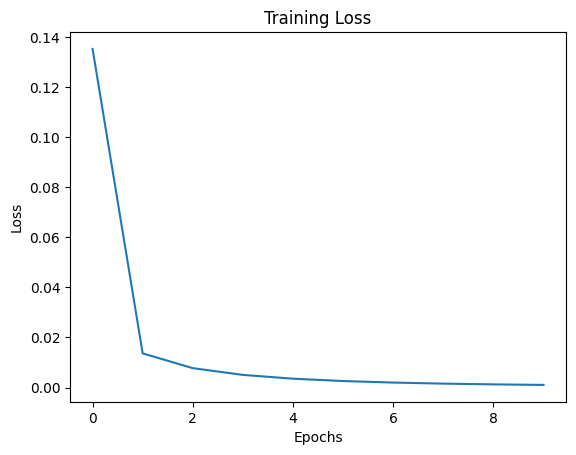

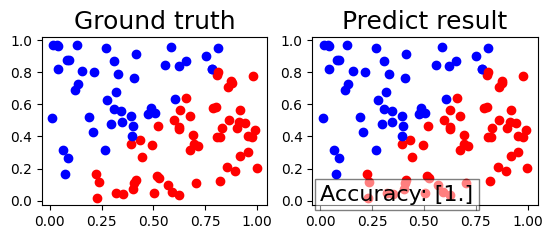

In [27]:
# 輸入數據和標籤
x, y= generate_linear()
# 訓練模型
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 10000
learning_rate = 0.1

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1, "ReLU"))
model.add_layer(Layer(hidden_size1, hidden_size2, "ReLU"))
model.add_layer(Layer(hidden_size2, output_size, "sigmoid"))
model.train(x, y, epochs, learning_rate)
model.show_result(x,y)

Epoch 0| Loss: 0.3195541430866618 | Accuracy: [0.57142857]
Epoch 1000| Loss: 0.020207820661455083 | Accuracy: [1.]
Epoch 2000| Loss: 0.005404617159968237 | Accuracy: [1.]
Epoch 3000| Loss: 0.0027336540448411224 | Accuracy: [1.]
Epoch 4000| Loss: 0.001760652053056333 | Accuracy: [1.]
Epoch 5000| Loss: 0.0012740425356660028 | Accuracy: [1.]
Epoch 6000| Loss: 0.0009869240791243576 | Accuracy: [1.]
Epoch 7000| Loss: 0.0008023134379490172 | Accuracy: [1.]
Epoch 8000| Loss: 0.0006733695564840137 | Accuracy: [1.]
Epoch 9000| Loss: 0.0005788903994345807 | Accuracy: [1.]
Accuracy: [1.]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.06504118]
Iter 2 | Ground truth: [1] | Prediction: [1.]
Iter 3 | Ground truth: [0] | Prediction: [0.03860305]
Iter 4 | Ground truth: [1] | Prediction: [1.]
Iter 5 | Ground truth: [0] | Prediction: [0.03119192]
Iter 6 | Ground truth: [1] | Prediction: [0.99999998]
Iter 7 | Ground truth: [0] | Prediction: [0.02519799]
Iter 8 | Ground truth: [1] | Prediction:

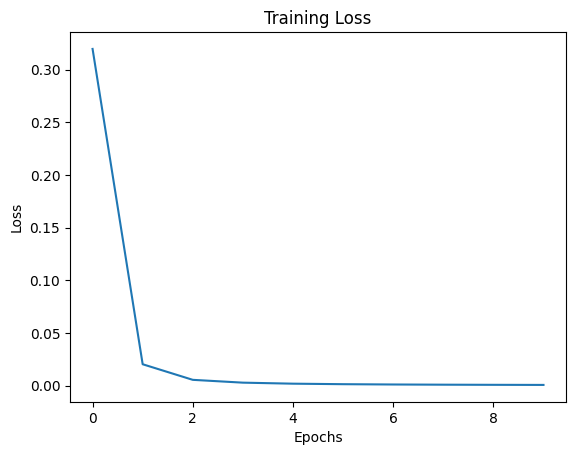

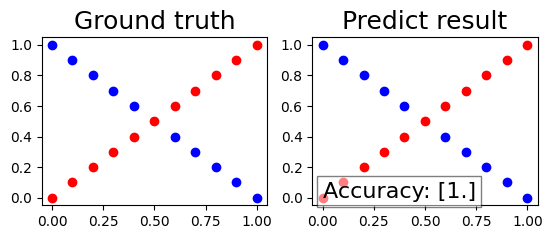

In [63]:
# 輸入數據和標籤
x, y= generate_XOR_easy()
# 訓練模型
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 10000
learning_rate = 0.1

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1, "ReLU"))
model.add_layer(Layer(hidden_size1, hidden_size2,   "ReLU"))
model.add_layer(Layer(hidden_size2, output_size, "sigmoid"))
model.train(x, y, epochs, learning_rate)
model.show_result(x,y)

# Try different lr

Epoch 0| Loss: 0.4764786559268508 | Accuracy: [0.48]
Epoch 1000| Loss: 0.20478529703087178 | Accuracy: [0.93]
Epoch 2000| Loss: 0.18226171232569377 | Accuracy: [0.94]
Epoch 3000| Loss: 0.16195829151212066 | Accuracy: [0.95]
Epoch 4000| Loss: 0.14404015186206107 | Accuracy: [0.97]
Epoch 5000| Loss: 0.12866497909738173 | Accuracy: [0.99]
Epoch 6000| Loss: 0.11570879325179778 | Accuracy: [0.98]
Epoch 7000| Loss: 0.1048719520720017 | Accuracy: [0.98]
Epoch 8000| Loss: 0.09580244514960913 | Accuracy: [0.98]
Epoch 9000| Loss: 0.08816992093346952 | Accuracy: [0.98]
Accuracy: [0.98]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.41381219]
Iter 2 | Ground truth: [1] | Prediction: [0.80011846]
Iter 3 | Ground truth: [0] | Prediction: [0.1535853]
Iter 4 | Ground truth: [1] | Prediction: [0.69781279]
Iter 5 | Ground truth: [1] | Prediction: [0.71833666]
Iter 6 | Ground truth: [0] | Prediction: [0.13532259]
Iter 7 | Ground truth: [0] | Prediction: [0.10012792]
Iter 8 | Ground truth: [0] 

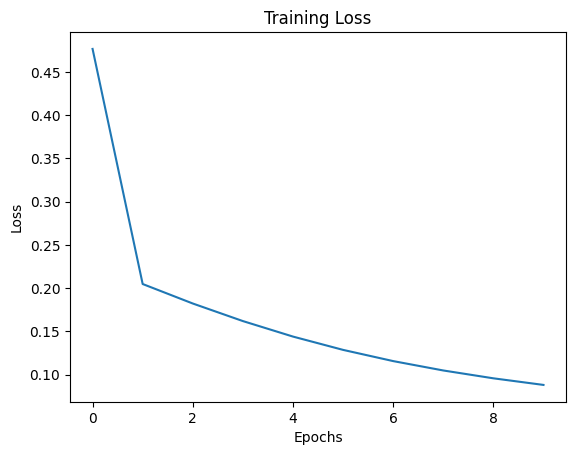

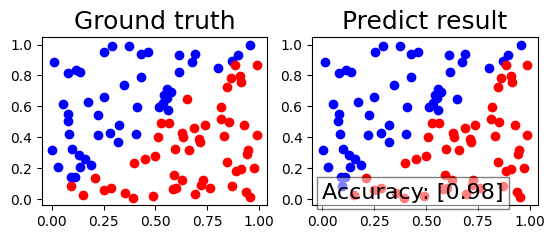

In [29]:
x, y= generate_linear()

    # 訓練參數
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 10000
learning_rate = 0.01

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1))
model.add_layer(Layer(hidden_size1, hidden_size2))
model.add_layer(Layer(hidden_size2, output_size))

# 訓練模型
model.train(x, y, epochs, learning_rate)
model.show_result(x,y)

Epoch 0| Loss: 0.3401421586595195 | Accuracy: [0.47619048]
Epoch 1000| Loss: 0.24841173659791843 | Accuracy: [0.42857143]
Epoch 2000| Loss: 0.24712604011437764 | Accuracy: [0.42857143]
Epoch 3000| Loss: 0.24588069756268904 | Accuracy: [0.38095238]
Epoch 4000| Loss: 0.24466108659819893 | Accuracy: [0.33333333]
Epoch 5000| Loss: 0.24345906487163257 | Accuracy: [0.38095238]
Epoch 6000| Loss: 0.2422691480864264 | Accuracy: [0.33333333]
Epoch 7000| Loss: 0.24108568022263585 | Accuracy: [0.33333333]
Epoch 8000| Loss: 0.23990130149533848 | Accuracy: [0.33333333]
Epoch 9000| Loss: 0.2387066064170192 | Accuracy: [0.33333333]
Accuracy: [0.47619048]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.38115456]
Iter 2 | Ground truth: [1] | Prediction: [0.49695942]
Iter 3 | Ground truth: [0] | Prediction: [0.40924259]
Iter 4 | Ground truth: [1] | Prediction: [0.49202238]
Iter 5 | Ground truth: [0] | Prediction: [0.43433169]
Iter 6 | Ground truth: [1] | Prediction: [0.4879944]
Iter 7 | Ground 

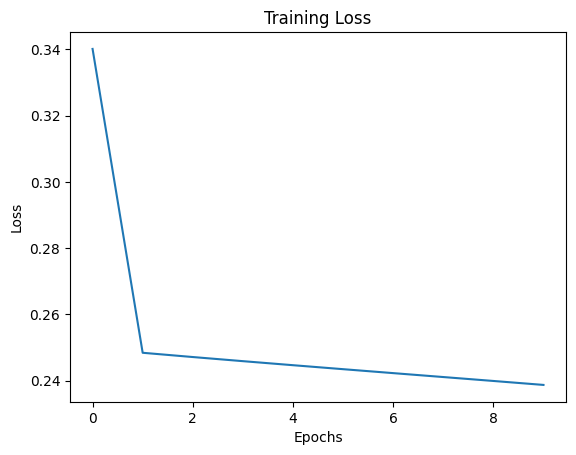

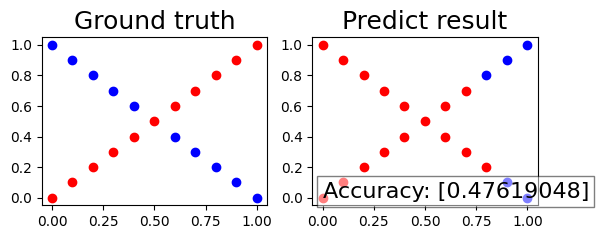

In [30]:
# 輸入數據和標籤
x, y= generate_XOR_easy()
# 訓練模型
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 10000
learning_rate = 0.01

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1))
model.add_layer(Layer(hidden_size1, hidden_size2))
model.add_layer(Layer(hidden_size2, output_size))

model.train(x, y, epochs, learning_rate)
model.show_result(x,y)

# Try different unit

Epoch 0| Loss: 0.3108147429681374 | Accuracy: [0.51]
Epoch 1000| Loss: 0.2486214511321783 | Accuracy: [0.49]
Epoch 2000| Loss: 0.24519132746277514 | Accuracy: [0.6]
Epoch 3000| Loss: 0.2314232907617379 | Accuracy: [0.77]
Epoch 4000| Loss: 0.17074462923645745 | Accuracy: [0.92]
Epoch 5000| Loss: 0.08775836419329588 | Accuracy: [0.97]
Epoch 6000| Loss: 0.05185357347899568 | Accuracy: [0.99]
Epoch 7000| Loss: 0.03673911423117993 | Accuracy: [0.99]
Epoch 8000| Loss: 0.028624460659711536 | Accuracy: [0.99]
Epoch 9000| Loss: 0.0235957460016416 | Accuracy: [0.99]
Accuracy: [0.99]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.03359875]
Iter 2 | Ground truth: [1] | Prediction: [0.71404789]
Iter 3 | Ground truth: [0] | Prediction: [0.03521729]
Iter 4 | Ground truth: [0] | Prediction: [0.21215842]
Iter 5 | Ground truth: [1] | Prediction: [0.83029825]
Iter 6 | Ground truth: [0] | Prediction: [0.08739732]
Iter 7 | Ground truth: [0] | Prediction: [0.03310454]
Iter 8 | Ground truth: [0] |

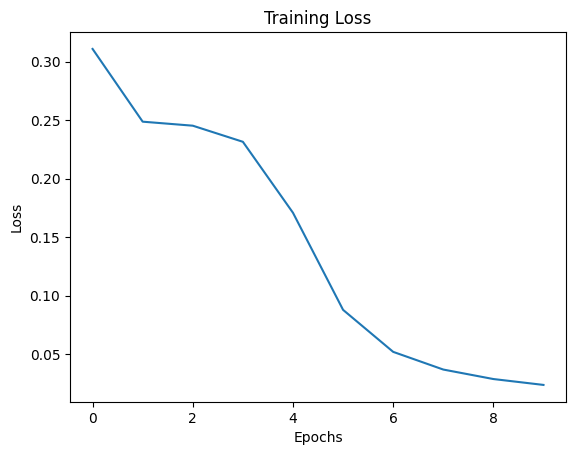

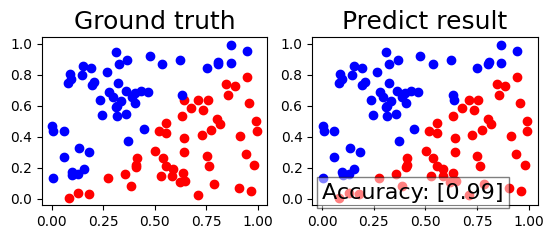

In [31]:
x, y= generate_linear()

# 訓練參數
input_size = 2
hidden_size1 = 1
hidden_size2 = 1
output_size = 1
epochs = 10000
learning_rate = 0.1

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1))
model.add_layer(Layer(hidden_size1, hidden_size2))
model.add_layer(Layer(hidden_size2, output_size))

# 訓練模型
model.train(x, y, epochs, learning_rate)
model.show_result(x,y)

Epoch 0| Loss: 0.26446219588884706 | Accuracy: [0.52380952]
Epoch 1000| Loss: 0.24939319030973614 | Accuracy: [0.52380952]
Epoch 2000| Loss: 0.2493709271490673 | Accuracy: [0.52380952]
Epoch 3000| Loss: 0.24934206509612794 | Accuracy: [0.52380952]
Epoch 4000| Loss: 0.24930338598238694 | Accuracy: [0.52380952]
Epoch 5000| Loss: 0.2492498319759917 | Accuracy: [0.52380952]
Epoch 6000| Loss: 0.24917330114358757 | Accuracy: [0.52380952]
Epoch 7000| Loss: 0.249060698444356 | Accuracy: [0.52380952]
Epoch 8000| Loss: 0.24889093996722078 | Accuracy: [0.52380952]
Epoch 9000| Loss: 0.24863071500963047 | Accuracy: [0.52380952]
Accuracy: [0.47619048]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.44104676]
Iter 2 | Ground truth: [1] | Prediction: [0.47481622]
Iter 3 | Ground truth: [0] | Prediction: [0.44908203]
Iter 4 | Ground truth: [1] | Prediction: [0.47537915]
Iter 5 | Ground truth: [0] | Prediction: [0.45688861]
Iter 6 | Ground truth: [1] | Prediction: [0.47593152]
Iter 7 | Ground 

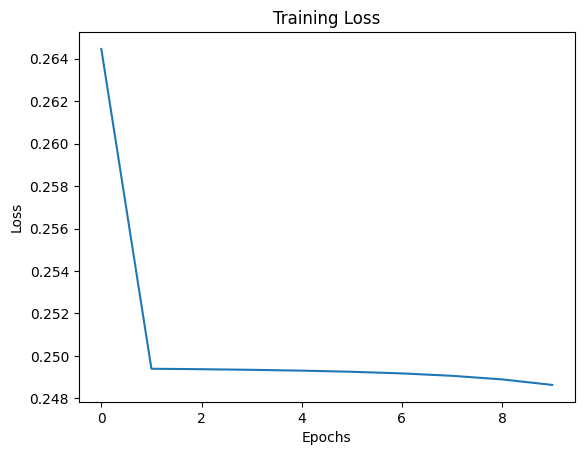

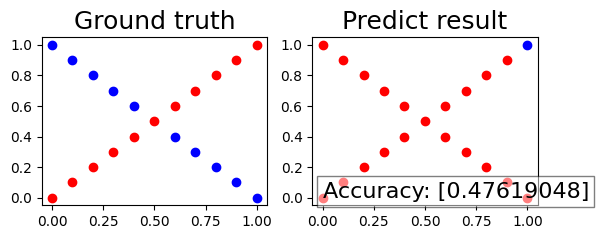

In [32]:
# 輸入數據和標籤
x, y= generate_XOR_easy()
# 訓練模型
input_size = 2
hidden_size1 = 2
hidden_size2 = 2
output_size = 1
epochs = 10000
learning_rate = 0.1

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1))
model.add_layer(Layer(hidden_size1, hidden_size2))
model.add_layer(Layer(hidden_size2, output_size))

model.train(x, y, epochs, learning_rate)
model.show_result(x,y)

# Try without activation function

Epoch 0| Loss: 37.79565538705967 | Accuracy: [0.12]
Epoch 1000| Loss: 0.07783795885495647 | Accuracy: [0.94]
Epoch 2000| Loss: 0.07733982014870974 | Accuracy: [0.94]
Epoch 3000| Loss: 0.07733942597400406 | Accuracy: [0.94]
Epoch 4000| Loss: 0.0773394257012509 | Accuracy: [0.94]
Epoch 5000| Loss: 0.07733942570106282 | Accuracy: [0.94]
Epoch 6000| Loss: 0.07733942570106273 | Accuracy: [0.94]
Epoch 7000| Loss: 0.0773394257010627 | Accuracy: [0.94]
Epoch 8000| Loss: 0.07733942570106268 | Accuracy: [0.94]
Epoch 9000| Loss: 0.0773394257010627 | Accuracy: [0.94]
Accuracy: [0.94]
Prediction : 
Iter 1 | Ground truth: [1] | Prediction: [0.66455042]
Iter 2 | Ground truth: [0] | Prediction: [-0.089374]
Iter 3 | Ground truth: [1] | Prediction: [0.81194039]
Iter 4 | Ground truth: [1] | Prediction: [1.19693362]
Iter 5 | Ground truth: [0] | Prediction: [0.13536996]
Iter 6 | Ground truth: [0] | Prediction: [-0.18155545]
Iter 7 | Ground truth: [1] | Prediction: [0.41149593]
Iter 8 | Ground truth: [1] | 

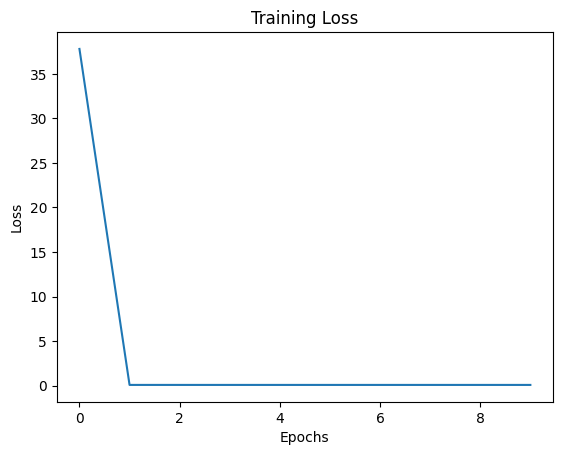

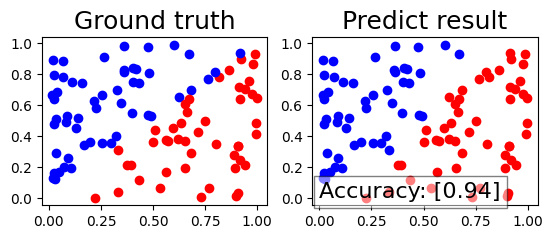

In [58]:
x, y= generate_linear()

# 訓練參數
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 10000
learning_rate = 0.001

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1,activation_function="linear"))
model.add_layer(Layer(hidden_size1, hidden_size2,activation_function="linear"))
model.add_layer(Layer(hidden_size2, output_size,activation_function="linear"))

# 訓練模型
model.train(x, y, epochs, learning_rate)
model.show_result(x,y)

Epoch 0| Loss: 274.8139321571954 | Accuracy: [0.04761905]
Epoch 1000| Loss: 0.24943318773526615 | Accuracy: [0.52380952]
Epoch 2000| Loss: 0.24943310657596682 | Accuracy: [0.52380952]
Epoch 3000| Loss: 0.249433106575964 | Accuracy: [0.52380952]
Epoch 4000| Loss: 0.24943310657596401 | Accuracy: [0.52380952]
Epoch 5000| Loss: 0.24943310657596363 | Accuracy: [0.52380952]
Epoch 6000| Loss: 0.24943310657596363 | Accuracy: [0.52380952]
Epoch 7000| Loss: 0.24943310657596354 | Accuracy: [0.52380952]
Epoch 8000| Loss: 0.24943310657596354 | Accuracy: [0.52380952]
Epoch 9000| Loss: 0.24943310657596354 | Accuracy: [0.52380952]
Accuracy: [0.52380952]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.47619048]
Iter 2 | Ground truth: [1] | Prediction: [0.47619048]
Iter 3 | Ground truth: [0] | Prediction: [0.47619048]
Iter 4 | Ground truth: [1] | Prediction: [0.47619048]
Iter 5 | Ground truth: [0] | Prediction: [0.47619048]
Iter 6 | Ground truth: [1] | Prediction: [0.47619048]
Iter 7 | Ground 

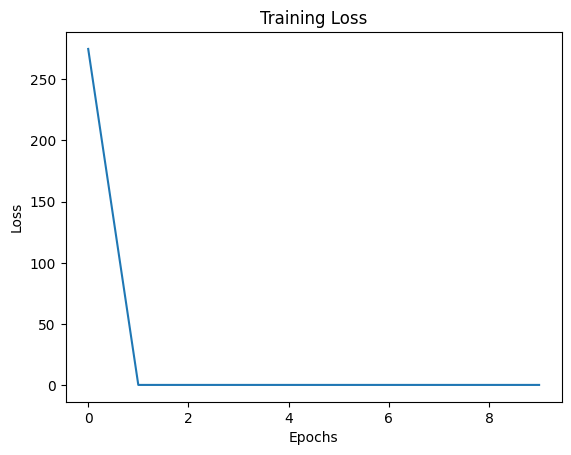

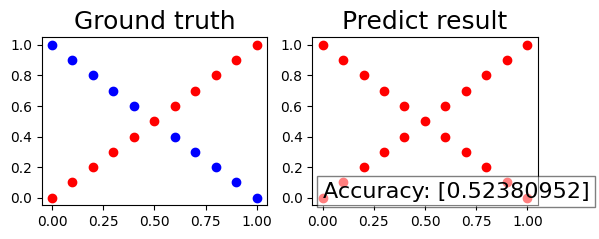

In [59]:
x, y= generate_XOR_easy()

# 訓練參數
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 10000
learning_rate = 0.001

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1,activation_function="linear"))
model.add_layer(Layer(hidden_size1, hidden_size2,activation_function="linear"))
model.add_layer(Layer(hidden_size2, output_size,activation_function="linear"))

# 訓練模型
model.train(x, y, epochs, learning_rate)
model.show_result(x,y)

# Try different opt

Epoch 0| Loss: 0.21701217086211724 | Accuracy: [0.64]
Epoch 1000| Loss: 0.009691323444365442 | Accuracy: [0.99]
Epoch 2000| Loss: 0.005181375201622872 | Accuracy: [1.]
Epoch 3000| Loss: 0.0035546401291512227 | Accuracy: [1.]
Epoch 4000| Loss: 0.0026832127629572715 | Accuracy: [1.]
Epoch 5000| Loss: 0.002125794441482552 | Accuracy: [1.]
Epoch 6000| Loss: 0.0017350112573566398 | Accuracy: [1.]
Epoch 7000| Loss: 0.0014460370156340356 | Accuracy: [1.]
Epoch 8000| Loss: 0.0012248077775267334 | Accuracy: [1.]
Epoch 9000| Loss: 0.0010512028168764974 | Accuracy: [1.]
Accuracy: [1.]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [6.25732661e-05]
Iter 2 | Ground truth: [0] | Prediction: [0.16680745]
Iter 3 | Ground truth: [0] | Prediction: [1.22414834e-06]
Iter 4 | Ground truth: [1] | Prediction: [0.99998464]
Iter 5 | Ground truth: [0] | Prediction: [1.10028444e-06]
Iter 6 | Ground truth: [1] | Prediction: [0.99998188]
Iter 7 | Ground truth: [0] | Prediction: [6.1307418e-06]
Iter 8 | Gro

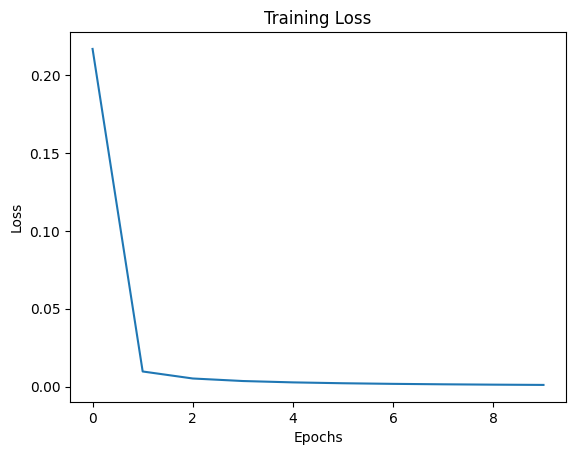

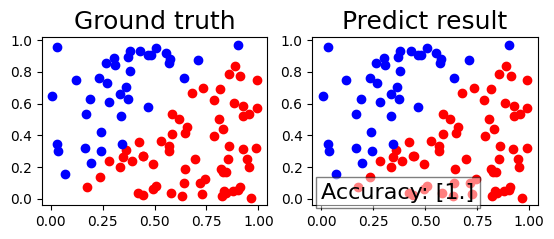

In [60]:
x, y= generate_linear()

# 訓練參數
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 10000
learning_rate = 0.1

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1))
model.add_layer(Layer(hidden_size1, hidden_size2))
model.add_layer(Layer(hidden_size2, output_size))

# 訓練模型
model.train(x, y, epochs, learning_rate,"momentum")
model.show_result(x,y)

Epoch 0| Loss: 0.2554873674882614 | Accuracy: [0.47619048]
Epoch 1000| Loss: 0.09479243867376247 | Accuracy: [0.9047619]
Epoch 2000| Loss: 0.02625333053610169 | Accuracy: [1.]
Epoch 3000| Loss: 0.007646305580328247 | Accuracy: [1.]
Epoch 4000| Loss: 0.002622224251025585 | Accuracy: [1.]
Epoch 5000| Loss: 0.0013101526332231692 | Accuracy: [1.]
Epoch 6000| Loss: 0.0008111335724625964 | Accuracy: [1.]
Epoch 7000| Loss: 0.0005667528743433223 | Accuracy: [1.]
Epoch 8000| Loss: 0.00042680727344223605 | Accuracy: [1.]
Epoch 9000| Loss: 0.0003379674278926797 | Accuracy: [1.]
Accuracy: [1.]
Prediction : 
Iter 1 | Ground truth: [0] | Prediction: [0.00214847]
Iter 2 | Ground truth: [1] | Prediction: [0.99983301]
Iter 3 | Ground truth: [0] | Prediction: [0.00287329]
Iter 4 | Ground truth: [1] | Prediction: [0.99992185]
Iter 5 | Ground truth: [0] | Prediction: [0.00487229]
Iter 6 | Ground truth: [1] | Prediction: [0.99994878]
Iter 7 | Ground truth: [0] | Prediction: [0.01197595]
Iter 8 | Ground tru

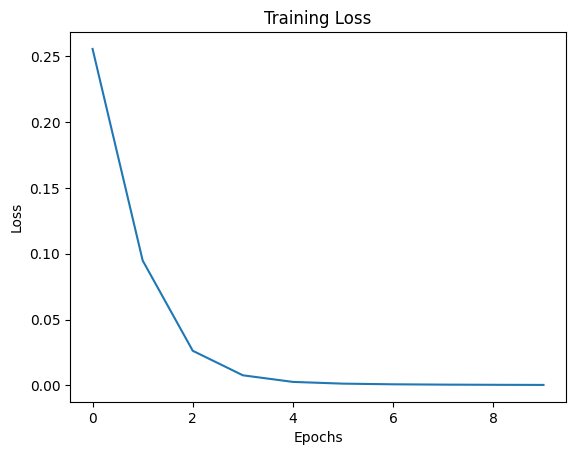

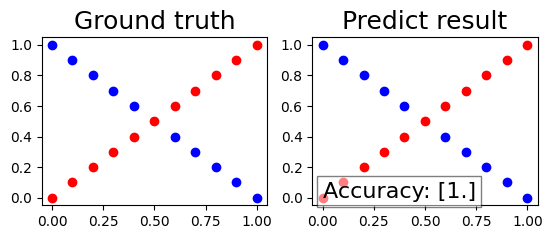

In [35]:
# 輸入數據和標籤
x, y= generate_XOR_easy()
# 訓練模型
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
epochs = 10000
learning_rate = 0.1

# 初始化神經網路
model = NeuralNetwork()
model.add_layer(Layer(input_size, hidden_size1))
model.add_layer(Layer(hidden_size1, hidden_size2))
model.add_layer(Layer(hidden_size2, output_size))

model.train(x, y, epochs, learning_rate,"momentum",0.9)
model.show_result(x,y)

# CNN